In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from google.colab import drive
import numpy as np
from datetime import datetime, timedelta

drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Colab Notebooks/'

filenames_list = glob(folder_path+'/requests_minute/*.csv')
filenames_list.sort()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
dfs_list = []
for filename in tqdm(filenames_list):
    df_i = pd.read_csv(filename, index_col=None)
    dfs_list.append(df_i)
print('Concatenating dataframes')
df_requests = pd.concat(dfs_list)

100%|██████████| 141/141 [00:07<00:00, 19.71it/s]


Concatenating dataframes


In [11]:
df_filled = df_requests.fillna(0)
print(df_filled.shape)
df_filled.reset_index(drop=True, inplace=True)

# Group by hour (60 minutes)
group_indices = df_filled.index // 60
print(f"Min group index: {group_indices.min()}, Max group index: {group_indices.max()}")
print(f"Number of unique groups: {len(group_indices.unique())}")

# Group as before
df = df_filled.drop(columns=['day', 'time'])
df_grouped = df.groupby(df.index // 60).mean()
df_grouped.reset_index(drop=True, inplace=True)

(203040, 202)
Min group index: 0, Max group index: 3383
Number of unique groups: 3384


In [12]:
# Define a start date
start_date = datetime(2025, 1, 1)  # Assuming data starts from January 1, 2025

# Create datetime index with hourly frequency
# The length matches the grouped dataframe
date_range = pd.date_range(start=start_date, periods=len(df_grouped), freq='h')

# Set this as the index of the dataframe
df_grouped.index = date_range

# Now we can extract hour and day_of_week from the datetime index if needed
df_grouped['hour'] = df_grouped.index.hour
df_grouped['day_of_week'] = df_grouped.index.dayofweek  # 0 = Monday, 6 = Sunday

# Extract target column
target_function = '59'
df_model = df_grouped[[target_function]].copy()
df_model.rename(columns={target_function: 'target'}, inplace=True)

<ipython-input-12-b0281c1e7f51>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_grouped['hour'] = df_grouped.index.hour
<ipython-input-12-b0281c1e7f51>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_grouped['day_of_week'] = df_grouped.index.dayofweek  # 0 = Monday, 6 = Sunday


In [13]:
# Skip the first 1248 hours (52 days)
df_model = df_model.iloc[1248:].copy()


df_model['hour'] = df_model.index.hour
df_model['day_of_week'] = df_model.index.dayofweek

print(df_model.head())

# Save the model dataset with datetime index
df_model.to_csv('/content/drive/MyDrive/Colab Notebooks/model_dataset_with_datetime.csv')

                           target  hour  day_of_week
2025-02-22 00:00:00  22194.583333     0            5
2025-02-22 01:00:00  20487.250000     1            5
2025-02-22 02:00:00  20038.716667     2            5
2025-02-22 03:00:00  21519.316667     3            5
2025-02-22 04:00:00  18344.950000     4            5


                     target  hour  day_of_week
datetime                                      
2025-01-01 00:00:00      92     0            2
2025-01-01 01:00:00      95     1            2
2025-01-01 02:00:00      68     2            2
2025-01-01 03:00:00      53     3            2
2025-01-01 04:00:00      40     4            2


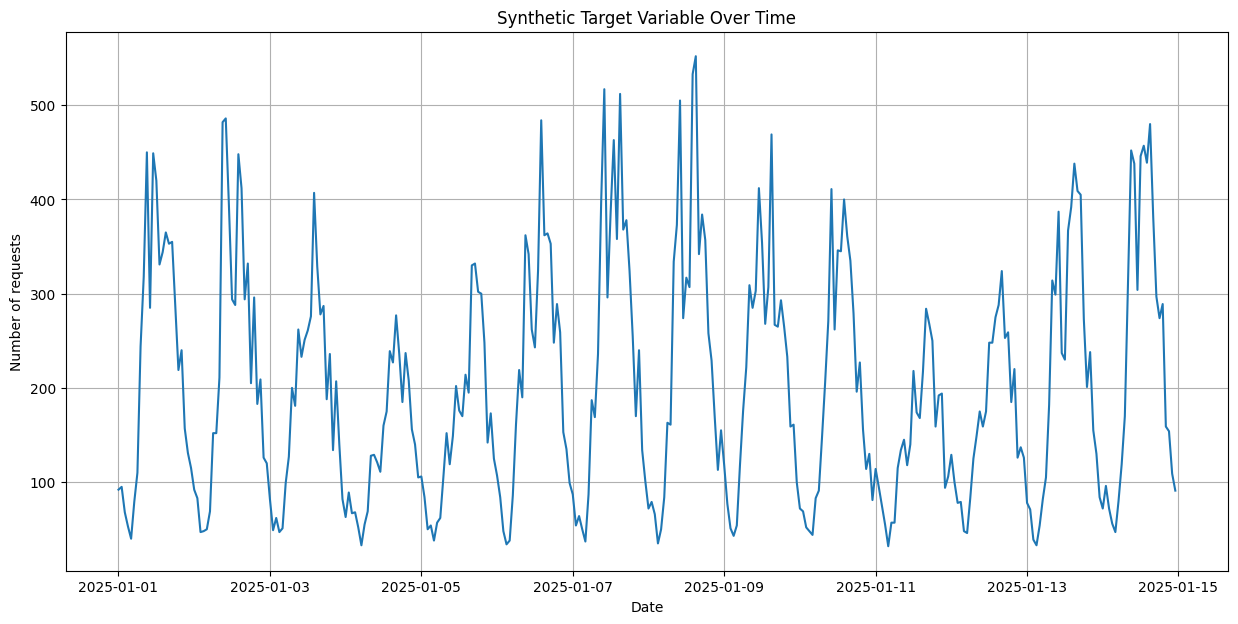

In [16]:
"""Synthetic dataset"""
# Configuration parameters
days_to_simulate = 14
start_date = datetime(2025, 1, 1)

# Define traffic patterns for all 24 hours
weekday_pattern = [
    0.2,  # 0:00
    0.15, # 1:00
    0.12, # 2:00
    0.1,  # 3:00
    0.1,  # 4:00
    0.2,  # 5:00
    0.3,  # 6:00
    0.4,  # 7:00
    0.6,  # 8:00
    0.8,  # 9:00
    0.8,  # 10:00
    0.7,  # 11:00
    0.7,  # 12:00
    0.8,  # 13:00
    0.85, # 14:00
    0.9,  # 15:00
    0.8,  # 16:00
    0.7,  # 17:00
    0.6,  # 18:00
    0.5,  # 19:00
    0.45, # 20:00
    0.4,  # 21:00
    0.3,  # 22:00
    0.25  # 23:00
]

weekend_pattern = [
    0.3,  # 0:00
    0.25, # 1:00
    0.2,  # 2:00
    0.2,  # 3:00
    0.15, # 4:00
    0.15, # 5:00
    0.2,  # 6:00
    0.3,  # 7:00
    0.35, # 8:00
    0.4,  # 9:00
    0.45, # 10:00
    0.5,  # 11:00
    0.6,  # 12:00
    0.65, # 13:00
    0.7,  # 14:00
    0.7,  # 15:00
    0.75, # 16:00
    0.8,  # 17:00
    0.8,  # 18:00
    0.7,  # 19:00
    0.6,  # 20:00
    0.5,  # 21:00
    0.4,  # 22:00
    0.35  # 23:00
]

# Day of week traffic factors (0=Monday, 6=Sunday)
day_factors = [0.9, 1.0, 1.0, 0.95, 0.8, 0.6, 0.7]

# Base invocation rate
base_invocations = 500

# Generate the data
np.random.seed(42)  # For reproducibility
data = []

for day in range(days_to_simulate):
    current_date = start_date + timedelta(days=day)
    day_of_week = current_date.weekday()  # 0=Monday, 6=Sunday
    is_weekend = day_of_week >= 5
    day_factor = day_factors[day_of_week]

    for hour in range(24):
        # Select the appropriate hourly pattern
        hourly_pattern = weekend_pattern if is_weekend else weekday_pattern
        time_factor = hourly_pattern[hour]

        # Add randomness (0.7-1.3 multiplier)
        random_factor = 0.7 + np.random.random() * 0.6

        # Calculate invocations
        invocations = round(base_invocations * day_factor * time_factor * random_factor)

        # Create timestamp
        timestamp = current_date.replace(hour=hour, minute=0, second=0, microsecond=0)

        # Add data point with the 4 requested features
        data.append({
            'datetime': timestamp,
            'target': invocations,
            'hour': hour,
            'day_of_week': day_of_week
        })

# Create DataFrame and save to CSV
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/synthetic_dataset.csv')

# Print the first few rows to verify
print(df.head())

#Plot the synthetic dataset
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['target'])
plt.title('Synthetic Target Variable Over Time')
plt.xlabel('Date')
plt.ylabel('Number of requests')
plt.grid(True)
plt.show()

